In [1]:
from os import walk, listdir
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import csv
import numpy as np 
from PIL import Image

In [2]:
# accessing to data 

path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'

nbr_class = 62 # len(next(walk(path_training))[1])  counting the number of classes 
print('number of classes : ', nbr_class)

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the training folder

DIR = path_training
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the training folder : ", counter)

#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the training folder 

# target is the format for the images that we want for convenience
# We rescale the images when we iterate over it and we will do a zoom and a flip  

target = (50,50)

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = target,
batch_size = counter,class_mode = 'binary', color_mode='rgb')

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the testing folder

DIR = path_testing
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the testing folder : ", counter)

#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the testing folder 

# target is the format for the images that we want for convenience
# We rescale the images when we iterate over it 

test_datagen = ImageDataGenerator( rescale =1./255)
test_set = test_datagen.flow_from_directory(path_testing,target_size = target,
batch_size = counter,class_mode = 'binary', color_mode='rgb')



number of classes :  62
number of images in the training folder :  4575
Found 4575 images belonging to 62 classes.
number of images in the testing folder :  2520
Found 2520 images belonging to 62 classes.


In [3]:
# Storing all the information in arrays for convenience 

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)

# Some explanations needed ... 

Shape of X_train :  (4575, 50, 50, 3)
Shape of y_train :  (4575,)
Shape of X_test :  (2520, 50, 50, 3)
Shape of y_test :  (2520,)


In [4]:
# We put our results to categorical 

y_train = to_categorical(y_train, nbr_class)
y_test = to_categorical(y_test, nbr_class)

print("Shape of y_train : ", y_train.shape)
print("Shape of y_test : ", y_test.shape)

# Some explanations needed ...

Shape of y_train :  (4575, 62)
Shape of y_test :  (2520, 62)


In [5]:
# We here construct our CNN architecture

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        36928     
                                                        

In [6]:
# We train here the model on the training_set 

eps = 15 # The number of time we want the model to train on the entire training_set 

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=eps, callbacks=mycallbacks) # We evaluate the loss and accuracy at the validation data 

Epoch 1/15
143/143 [==============================] - 76s 516ms/step - loss: 2.6702 - accuracy: 0.3709 - val_loss: 1.0915 - val_accuracy: 0.7103
Epoch 2/15
143/143 [==============================] - 61s 425ms/step - loss: 1.1795 - accuracy: 0.7001 - val_loss: 0.6069 - val_accuracy: 0.8540
Epoch 3/15
143/143 [==============================] - 50s 352ms/step - loss: 0.7517 - accuracy: 0.7937 - val_loss: 0.3913 - val_accuracy: 0.9183
Epoch 4/15
143/143 [==============================] - 52s 361ms/step - loss: 0.5096 - accuracy: 0.8570 - val_loss: 0.2904 - val_accuracy: 0.9377
Epoch 5/15
143/143 [==============================] - 51s 354ms/step - loss: 0.3969 - accuracy: 0.8800 - val_loss: 0.2394 - val_accuracy: 0.9456
Epoch 6/15
143/143 [==============================] - 53s 371ms/step - loss: 0.3143 - accuracy: 0.9021 - val_loss: 0.2350 - val_accuracy: 0.9460
Epoch 7/15
143/143 [==============================] - 53s 373ms/step - loss: 0.2590 - accuracy: 0.9178 - val_loss: 0.2444 - val_ac

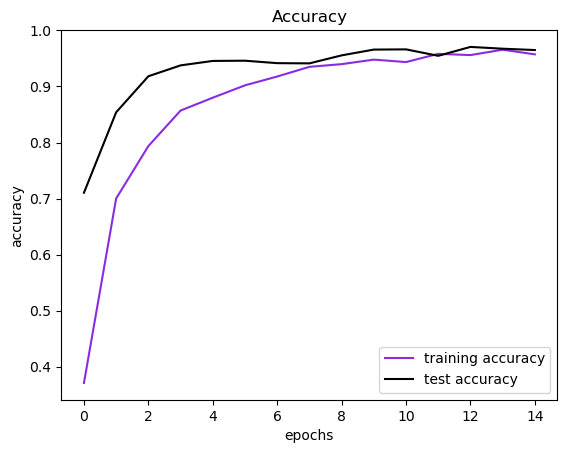

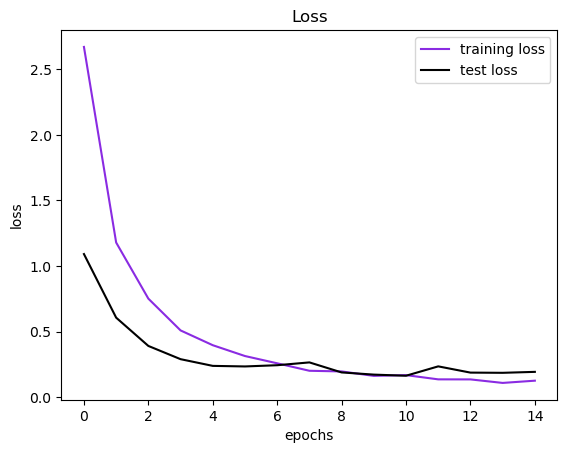

In [7]:
# Results of performances 

plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy', color = 'blueviolet')
plt.plot(anc.history['val_accuracy'], label='test accuracy', color = 'black')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss', color = 'blueviolet')
plt.plot(anc.history['val_loss'], label='test loss', color = 'black')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
# Here is the code to write the results in a CSV for kaggle 

predicted_classes = np.argmax(model.predict(X_test), axis=-1)
print(len(predicted_classes))

print(len(X_test), len(y_test))

with open('final.csv', 'w', newline='') as csvfile:
    fieldnames = ['Id', 'Category']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(predicted_classes)): 
        writer.writerow({'Id' : test_set.filenames[i], 'Category' : predicted_classes[i]})

79/79 [==============================] - 6s 70ms/step
2520
2520 2520


In [9]:
# Here is a code to save all ppm in jpeg in a directory called names (must be created)

# get the path/directory
folder_dir = "eval_kaggle1"

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img.save("names" + '/' + image.replace('.ppm','.jpg'), format = 'JPEG') 

In [16]:
# We store all of the images from the kaggle folder in an array 
# recall that target has been defined above 

images = [] 

# get the path/directory
folder_dir = 'eval_kaggle1'

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img = img.resize(target) # (30,30) as an example 
        img = np.asarray(img)
        images.append(img) 

images = np.array(images)

print(X_train.shape)
print(type(X_train))

print(images.shape)
print(type(images))

(4575, 50, 50, 3)
<class 'numpy.ndarray'>
(202, 50, 50, 3)
<class 'numpy.ndarray'>


In [17]:
# We print there the predictions for the dataset of kaggle 

print("[INFO] evaluating network...")

predictions = model.predict(images).argmax(axis=1)
print(predictions)
print(len(predictions))


[INFO] evaluating network...
7/7 [==============================] - 1s 145ms/step
[ 8 45 27 61 19 20 21  7 19  6 45 40 60 41  8 60 35 51 40 59 39 56 40 22
 21 20 59  4  9 61  4 19 21 25 19 37  1 14 18 61 24 14 28  1 61  1 28 13
 58 56 56 31 22 61  8 39 31  8 32 33 13 19 17 47 38 38 24  1 35 61 17 32
 35 28  9 10 47  6 24 17  7 32 12 28 22 28 32 54 28 13 34 14 21  8  6 25
 51 14 39 18 35 13 38 40 30 22 59  4 60 59 19 18 34 32 56 56 13  4 12  9
 30 13 45  4 32 27 17 34 14 61 33 32  4 22 32 54 33 34 37 39 29  4 47 39
 35 25 56 39  6  7 30 39 39 22 29 39 29 46 14 19 13 36 17 35 35 13 31 35
  1  9 46 35 29 56 38  4 14 35 56 24  1 18 38  8 38 13  4 45 35 12  1 39
 28 13 44 19  4 24 31 56 60 35]
202


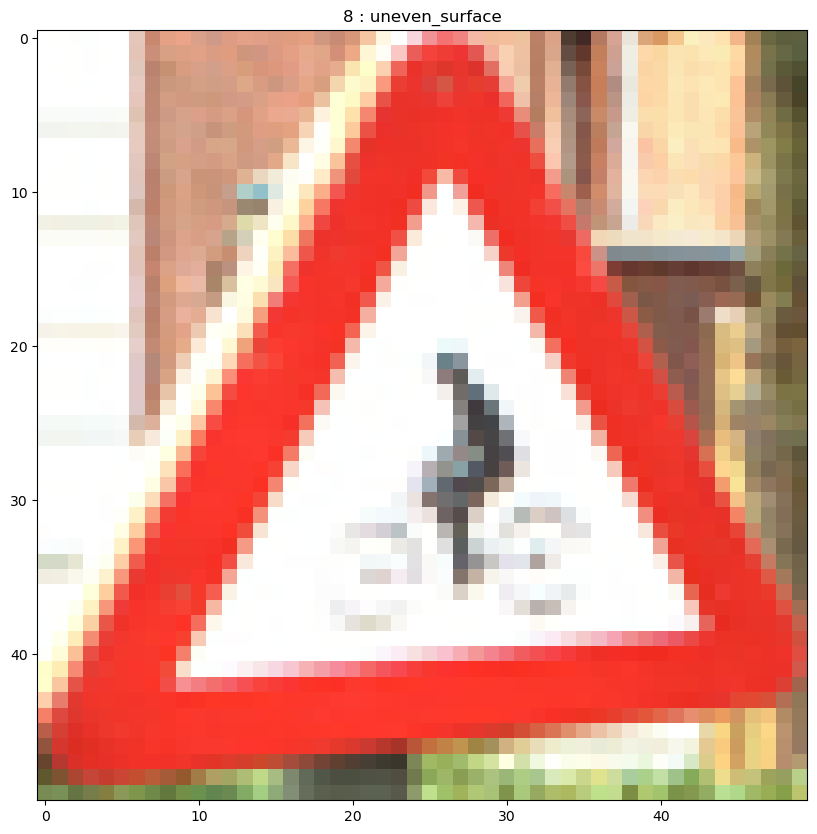

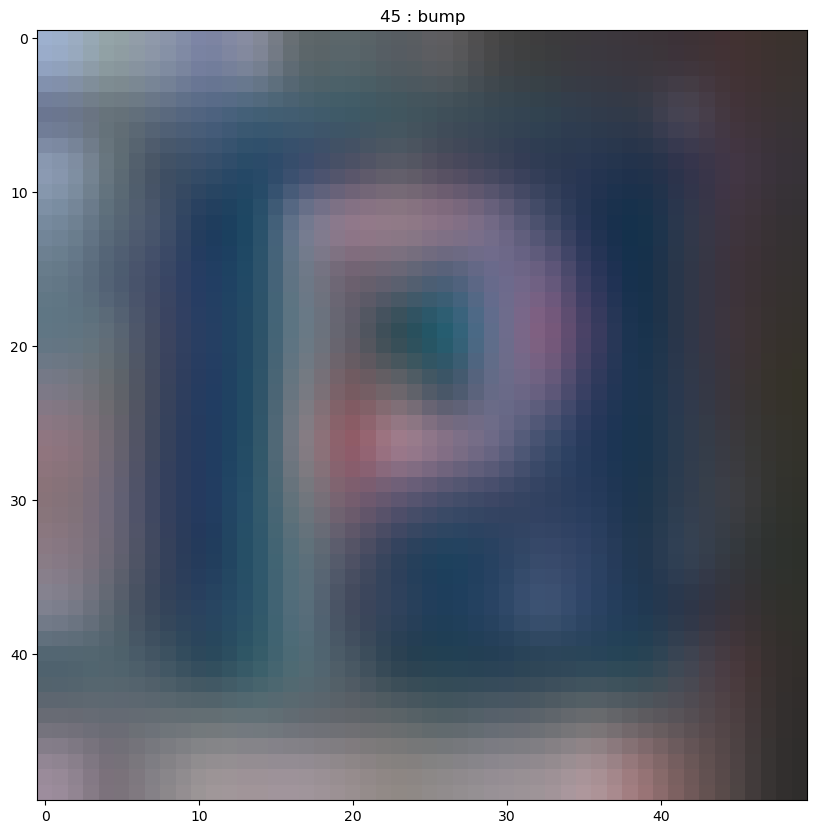

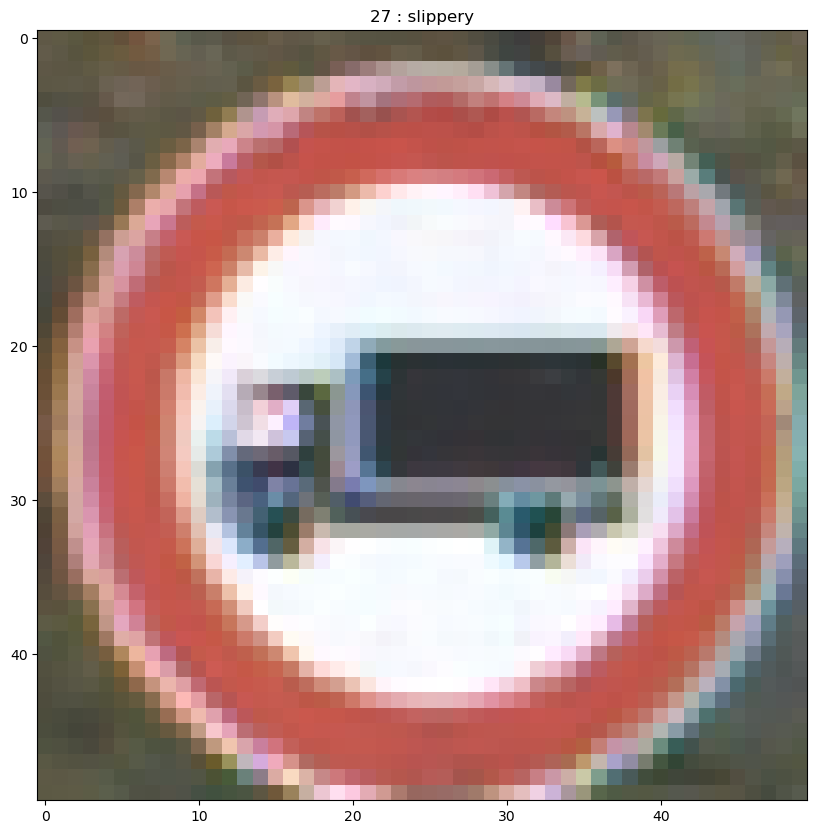

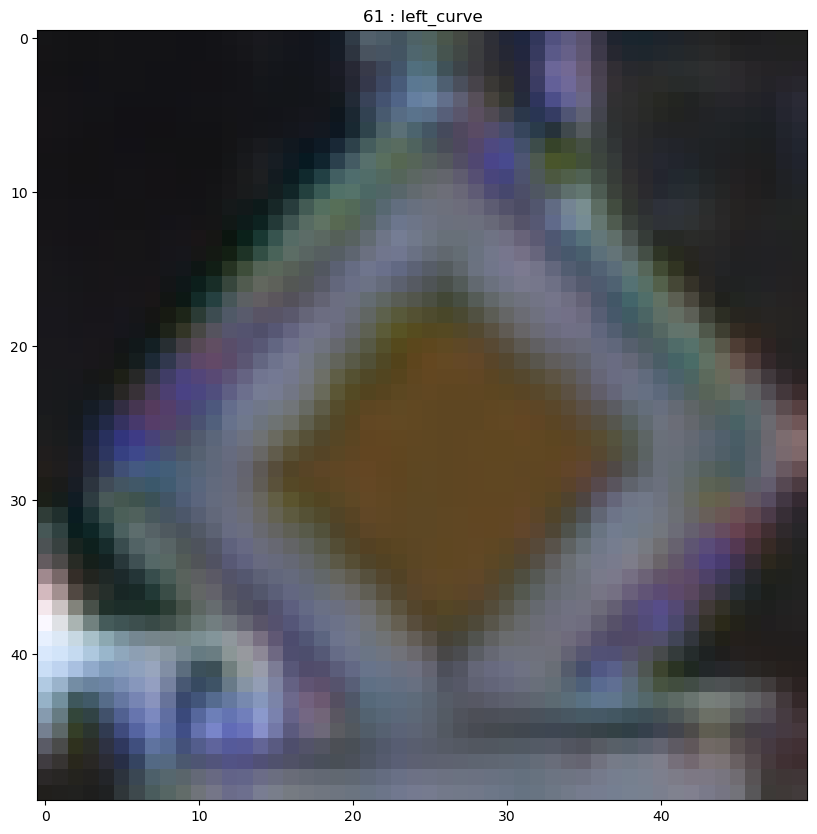

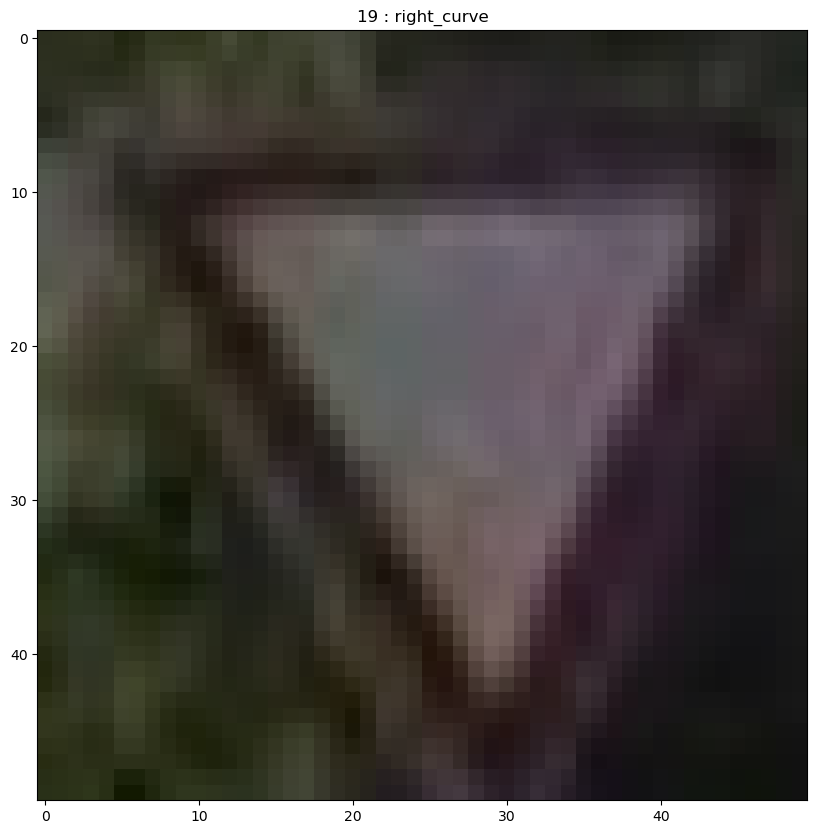

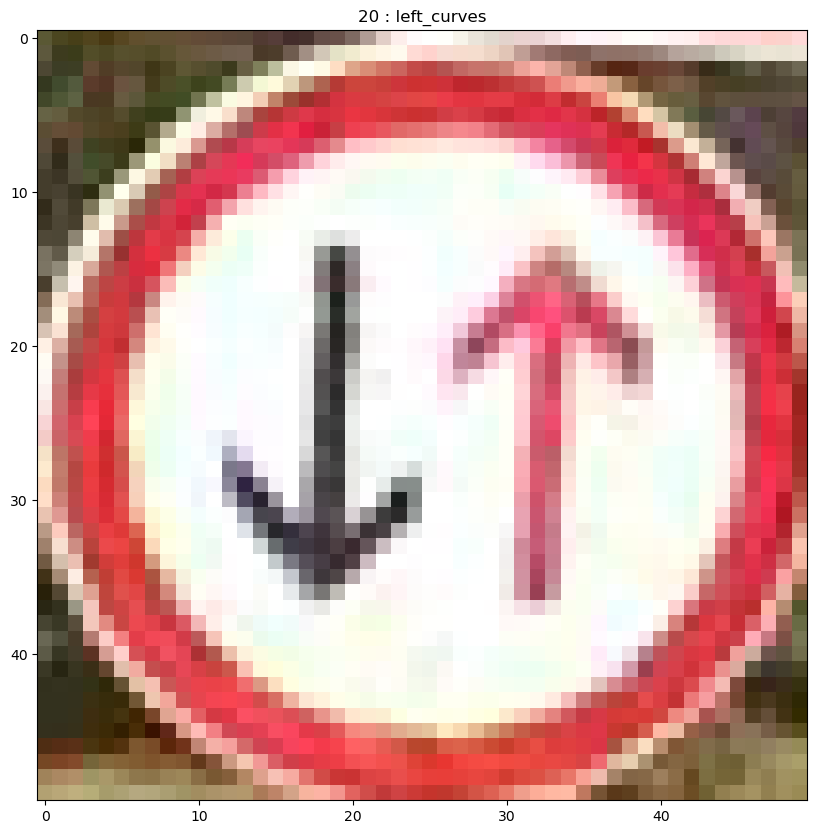

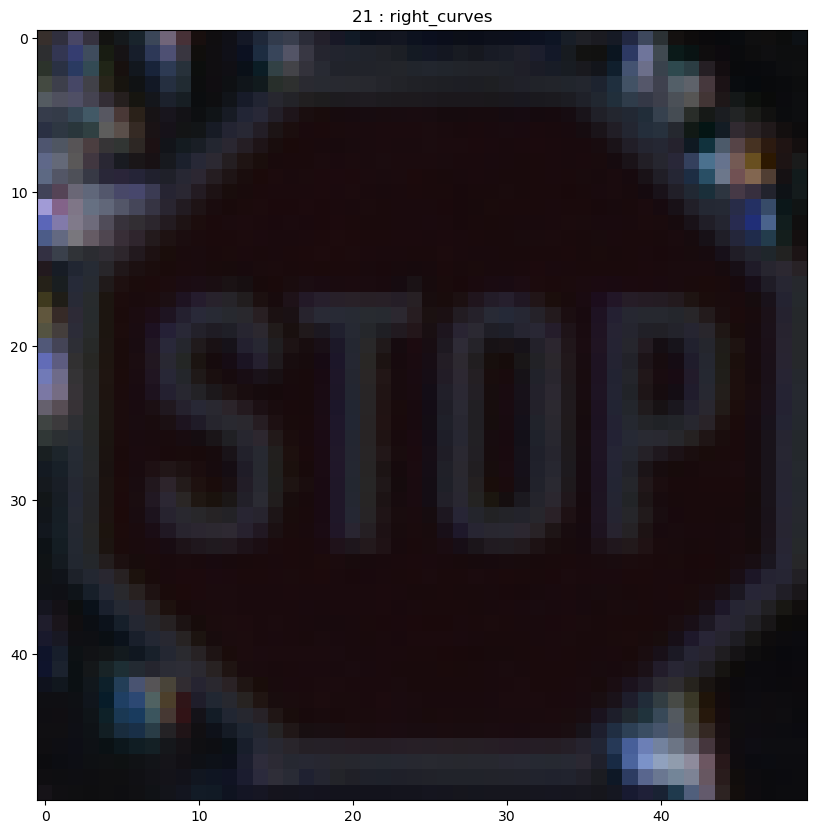

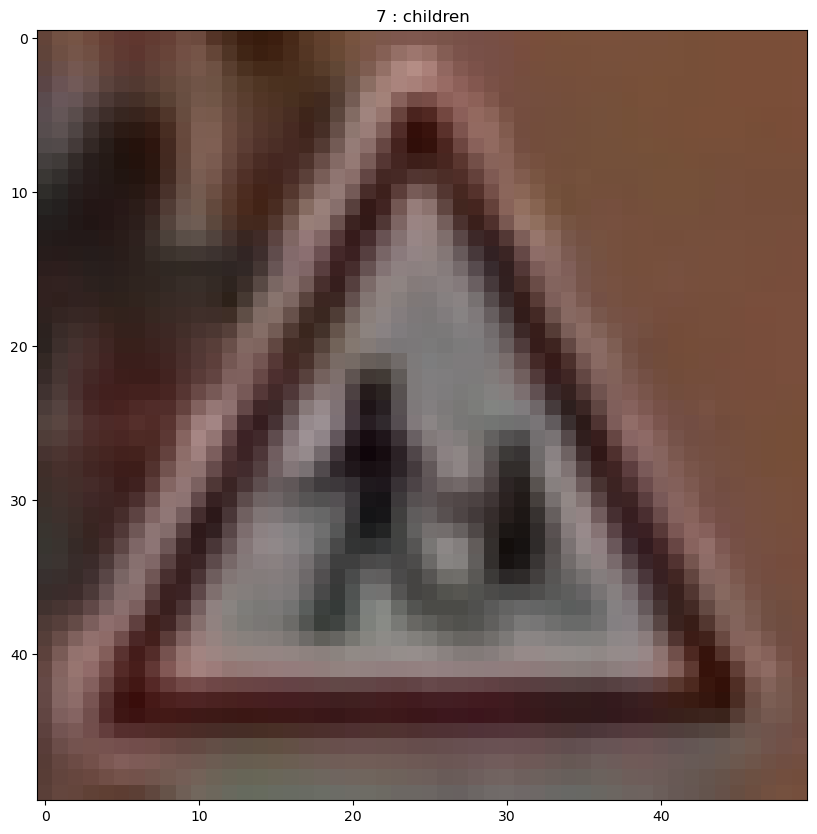

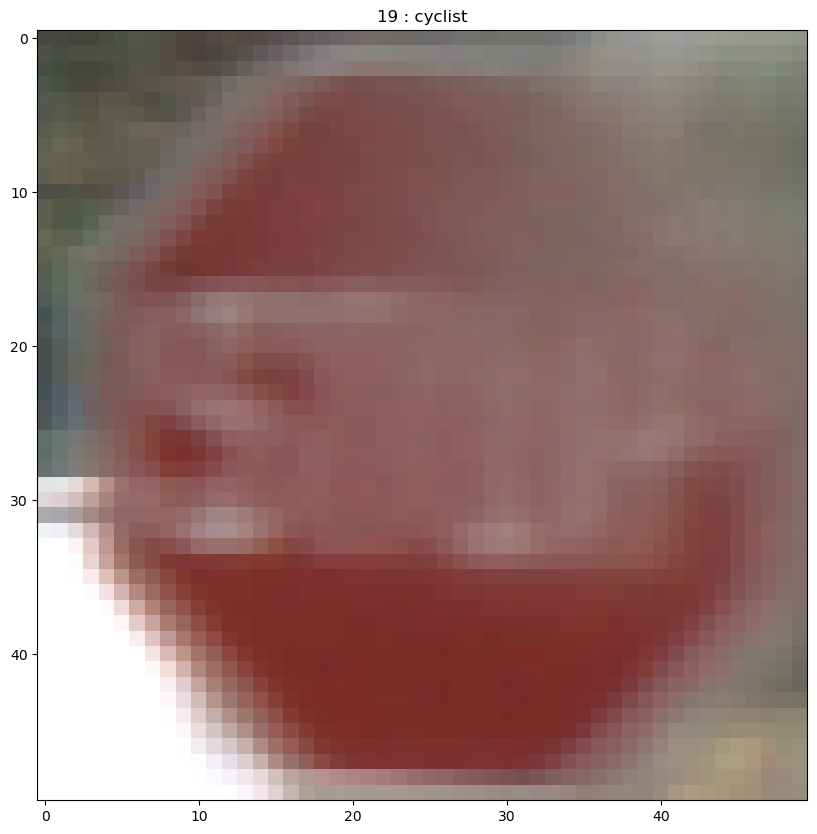

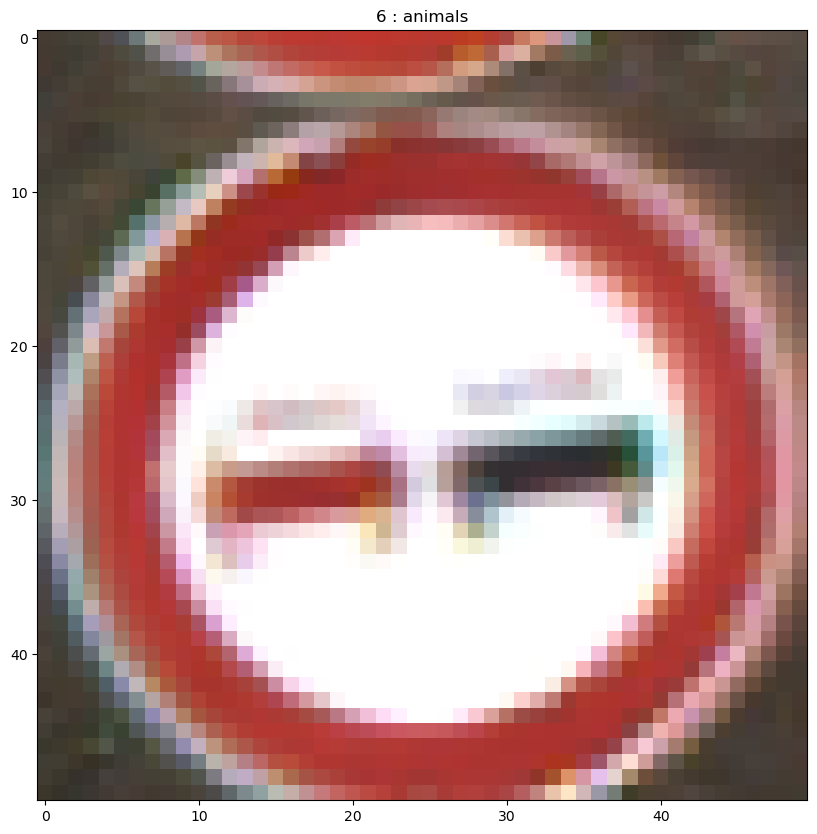

In [18]:
# We will store the data in dict.csv in a dict 

data = {}

with open('dict.csv', 'r') as f:
    d_reader = csv.DictReader(f, fieldnames=["num", "sign"])

    #get fieldnames from DictReader object and store in list
    for row in d_reader:
        data[row['num']] = row['sign']

# We then print the image with num and the sign predicted as a title 
 
for i in range(10): 
    plt.figure(figsize = (10,10))
    plt.imshow(images[i])
    sign = data[str(i)]
    plt.title(str(predictions[i]) + " : " + str(sign))